## Text Embedding Analysis Through Legal-BERT

### Dataset Reading

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("../data/metadata_cleaned.csv")

df.head()

,filename,author,type,text,act_quote_sentences_removed
0,regina_v_wing_chong.txt,Crease,case,"CREASE, J. 1885. REGINA v. WING CHONG. \r\n\r\...",12
1,wong_hoy_woon_v_duncan.txt,Crease,case,"CREASE, J.\r\n\r\nWONG HOY WOON v. DUNCAN.\r\n...",0
2,regina_v_mee_wah.txt,Begbie,case,BRITISH COLUMBIA REPORTS.\r\n\r\nREGINA v. MEE...,0
3,regina_v_victoria.txt,Begbie,case,"OF BRITISH COLUMBIA.\r\n\r\nREGINA r, CORPORAT...",0
4,quong_wing_v_the_king.txt,Fitzpatrick,case,QUONG WING v. THE KING. CAN. \r\n\r\nSupreme ...,0


### Naive Word Embedding Analysis

In [2]:
# Define a function to clean the text
import re

def clean_text(text):
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    
    return text.strip()

In [3]:
from nltk.tokenize import word_tokenize

# Create the large corpus by joining all text from all authors
all_text = " ".join(df["text"].tolist())

clean_text = clean_text(all_text)

In [4]:
# Load the tokenizer and model from Hugging Face
from transformers import AutoTokenizer, AutoModel
import torch

# We will use the Legal-BERT model for this task
tokenizer = AutoTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
model = AutoModel.from_pretrained('nlpaueb/legal-bert-base-uncased')

# set the model to evaluation mode
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [5]:
# Create the word embeddings
# Tokenize the cleaned text into words
tokens = word_tokenize(clean_text)

# Get unique words to avoid redundant computation
unique_tokens = list(set(tokens))

# Print the shape of unique tokens
print(f'There are {len(unique_tokens)} unique tokens in this corpus.')

There are 4898 unique tokens in this corpus.


In [6]:
# Prepare a dictionary to store word embeddings
word_embeddings = {}

# Batch processing for efficiency
batch_size = 32
batches = [unique_tokens[i:i + batch_size] for i in range(0, len(unique_tokens), batch_size)]

for batch in batches:
    # Tokenize the batch
    batch_inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=10)
    with torch.no_grad():
        batch_outputs = model(**batch_inputs)
        # Use the [CLS] token embedding as the word embedding
        for i, word in enumerate(batch):
            word_embedding = batch_outputs.last_hidden_state[i, 0, :].numpy()
            word_embeddings[word] = word_embedding

In [7]:
# Print embedding for the word of interest 'chinese'

print(f"Embedding for 'chinese':\n{word_embeddings.get('chinese')}")

Embedding for 'chinese':
[-6.20929480e-01 -1.41668797e-01  6.38974726e-01  5.66694401e-02
  2.49501377e-01  3.55757177e-01 -9.64464024e-02  3.54797840e-01
 -2.72698402e-01 -6.37608409e-01  1.72131136e-01  5.87600172e-01
  5.80051318e-02 -1.98575512e-01 -6.22221828e-01  6.23441935e-01
 -2.84136474e-01 -2.01131552e-01 -1.16011664e-01  3.39486420e-01
 -1.49678394e-01  4.16029304e-01  4.64203477e-01 -4.62919444e-01
  3.87407959e-01  6.31607771e-01  6.86673105e-01  2.19446778e-01
 -3.76840830e-01  1.29365414e-01 -2.28451818e-01 -2.85087198e-01
  3.50296557e-01  4.33140159e-01 -4.69817996e-01  2.95414269e-01
  5.21591008e-02 -2.85922885e-02  4.41664040e-01  2.89366692e-01
  3.54159415e-01 -7.48492122e-01  7.74234757e-02 -1.15738638e-01
 -1.74301580e-01  1.22696996e-01 -2.15352511e+00 -3.29316407e-01
  1.01312399e-02 -3.54923829e-02 -1.23483047e-01  6.59714818e-01
 -8.31633061e-03  6.29764497e-01  6.69251680e-01 -4.71155524e-01
  7.91470930e-02 -6.24099612e-01 -4.18075144e-01 -6.55562580e-02


In [8]:
# Compute cosine similarity between all words with Chinese in the model
from scipy.spatial.distance import cosine

similarity_scores = {}

for other_word in word_embeddings.keys():
    if other_word != "chinese":
        similarity = 1 - cosine(word_embeddings["chinese"], word_embeddings[other_word])
        similarity_scores[other_word] = similarity

# Sort by cosine similarity
sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most similar words
print("Top 10 most similar words to 'chinese':")
for word, score in sorted_similarity[:10]:
    print(f"{word}: {score:.4f}")

Top 10 most similar words to 'chinese':
japanese: 0.8790
chong: 0.8652
alien: 0.8581
fourteen: 0.8564
jaw: 0.8557
king: 0.8519
hong: 0.8516
contradiction: 0.8485
cousin: 0.8480
inferior: 0.8472


In [9]:
# Compute cosine similarity between all words with Chinaman in the model

similarity_scores = {}

for other_word in word_embeddings.keys():
    if other_word != "chinaman":
        similarity = 1 - cosine(word_embeddings["chinaman"], word_embeddings[other_word])
        similarity_scores[other_word] = similarity

# Sort by cosine similarity
sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most similar words
print("Top 10 most similar words to 'chinaman'")
for word, score in sorted_similarity[:10]:
    print(f"{word}: {score:.4f}")

Top 10 most similar words to 'chinaman'
provei: 0.9922
clamor: 0.9916
totally: 0.9916
today: 0.9914
chinamen: 0.9911
interred: 0.9910
unequalled: 0.9909
surely: 0.9906
semitropical: 0.9904
quickly: 0.9904


In [10]:
# Generate a t-SNE plot for visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)

embeddings = np.array(list(word_embeddings.values()))
tsne_results = tsne.fit_transform(embeddings)

In [11]:
# Create a DataFrame for visualization
import plotly.express as px

df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])
df_tsne['word'] = list(word_embeddings.keys())
# Highlight the word 'chinese' in the plot
keywords = ["chinese", "china", "chinaman", "chinamen"]
df_tsne['highlight'] = df_tsne['word'].apply(lambda x: x if x in keywords else '')

fig = px.scatter(
    df_tsne,
    x='x',
    y='y',
    title='t-SNE Visualization of legal-BERT Word Embeddings',
    color='highlight',                        
    hover_data=['word'], 
    text= 'highlight',
    height=600,
    width=800
)

fig.show()

### Text Embedding and Analysis of Crease and Begbie Corpus

In [12]:
# Compile the Crease texts into a single text list
crease_texts = df[df['author'] == 'Crease']['text'].tolist()

# Compile the Begbie texts into a single text list
begbie_texts = df[df['author'] == 'Begbie']['text'].tolist()

# Combine both lists in a dictionary
judge_dict = {
    'Crease': crease_texts,
    'Begbie': begbie_texts
}

In [13]:
# Define a function to embed text using the model
from typing import Union, List

def embed_text(
    text: str,
    focus_token: Union[str, List[str]] = None,
    window: int = 5,
    tokenizer=tokenizer,
    model=model)-> np.ndarray:
    """
    text: the raw string
    focus_token: either a single word, or a list of words to look for
    window: how many tokens on each side to include
    tokenizer: HuggingFace tokenizer
    model: BERT model
    """
    # Run the model once
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden = outputs.last_hidden_state.squeeze(0) 

    if focus_token is None:
        return hidden[0].cpu().numpy()
    
    # Normalize to list
    keywords = (
        [focus_token] if isinstance(focus_token, str)
        else focus_token
    )

    # Pre-tokenize each keyword to its subtoken ids
    kw_token_ids = {
        kw: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(kw))
        for kw in keywords
    }

    input_ids = inputs["input_ids"].squeeze(0).tolist()
    spans = []  # list of (start, end) index pairs

    # find every match of every keyword
    for kw, sub_ids in kw_token_ids.items():
        L = len(sub_ids)
        for i in range(len(input_ids) - L + 1):
            if input_ids[i:i+L] == sub_ids:
                spans.append((i, i+L))

    if not spans:
        # fallback on CLS vector
        return hidden[0].cpu().numpy()

    # For each span, grab the window around it
    vecs = []
    for (start, end) in spans:
        lo = max(1, start - window)
        hi = min(hidden.size(0), end + window)
        # mean‑pool over all tokens in this extended window
        span_vec = hidden[lo:hi].mean(dim=0).cpu().numpy()
        vecs.append(span_vec)

    # Average across all spans
    return np.mean(np.stack(vecs, axis=0), axis=0)

In [14]:
from nltk import sent_tokenize 
# Create a dictionary to hold the mentionings of "Chinese" by author
judge_snippets = {}

keywords = ["Chinese", "China", "Chinaman", "Chinamen", "immigrant", "immigrants", "immigration"]
for auth, texts in judge_dict.items():
    snippets = []
    for txt in texts:
        sentence = sent_tokenize(txt)
        for sent in sentence:
            if any(keyword in sent for keyword in keywords):
                snippets.append(sent)
    judge_snippets[auth] = snippets

In [15]:
# Investigate the length of the snippets
n_snippet = {auth: len(snippets) for auth, snippets in judge_snippets.items()}

print("Snippet size by author:")
for auth, num in n_snippet.items():
    print(f"{auth}: {num}")
    

Snippet size by author:
Crease: 137
Begbie: 108


In [16]:
# Define an ethnicity anchor, not including "chinese"
ethnicities = [
    "Japanese",   "Korean",    "Vietnamese",
    "Filipino",    "Thai",       "Malay",     "Indian",
    "Pakistani",   "Bangladeshi","Nepalese",  "Tibetan",
    "Arab",        "Persian",    "Turkish",   "Slavic",
    "Germanic",    "Celtic",     "Slavic",    "Romani",
    "Jewish",      "Zulu",       "Xhosa",     "Maori",
    "Sami",        "Berber",     "Tamil",     "Punjabi",
    "Bengali",     "Kazakh",     "Uyghur"
]

# Create embeddings
eth_vecs = []
for e in ethnicities:
    eth_vecs.append(embed_text(e)[:256])  # Keep only the first 256 dimensions
    
eth_anchor = np.mean(eth_vecs, axis=0)

In [17]:
# Create embeddings
embeddings_dict = {'Crease': [], 'Begbie': []}

for auth, snippets in judge_snippets.items():
    for snip in snippets:
        v = embed_text(snip, focus_token=keywords, window=15)
        embeddings_dict[auth].append(v[:256])


In [18]:
# Create embeddings that subtract the ethnicity anchor
subtracted_embeddings_dict = {'Crease': [], 'Begbie': []}

for auth, embeddings in embeddings_dict.items():
    for emb in embeddings:
        v = emb - eth_anchor
        subtracted_embeddings_dict[auth].append(v)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute per author mean and cosine similarity
mean_crease = np.mean(embeddings_dict["Crease"], axis=0, keepdims=True)  
mean_begbie = np.mean(embeddings_dict["Begbie"], axis=0, keepdims=True)

# Compute the pairwise cosine similarity
sim_crease_begbie = cosine_similarity(mean_crease, mean_begbie)[0, 0] 

print(f"Cosine similarity between Crease and Begbie: {sim_crease_begbie:.4f}")

Cosine similarity between Crease and Begbie: 0.9777


In [20]:
# Compute per author mean and cosine similarity
subtracted_mean_crease = np.mean(subtracted_embeddings_dict["Crease"], axis=0, keepdims=True)  
subtracted_mean_begbie = np.mean(subtracted_embeddings_dict["Begbie"], axis=0, keepdims=True)

# Compute the pairwise cosine similarity
sim_crease_begbie_sub = cosine_similarity(subtracted_mean_crease, subtracted_mean_begbie)[0, 0] 

print(f"Cosine similarity between Crease and Begbie with ethical axis removed: {sim_crease_begbie_sub:.4f}")

Cosine similarity between Crease and Begbie with ethical axis removed: 0.9969


In [21]:
# We check if the cosine similarity is lower when one subtracted the ethnicity anchor but not the other
sim_crease_sub_begbie = cosine_similarity(mean_crease, subtracted_mean_begbie)[0, 0]
sim_sub_crease_begbie = cosine_similarity(subtracted_mean_crease, mean_begbie)[0, 0]

print(f"Cosine similarity between Crease and Begbie with Begbie removed ethnical axis: {sim_crease_sub_begbie:.4f}")
print(f"Cosine similarity between Crease and Begbie with Crease removed ethnical axis: {sim_sub_crease_begbie:.4f}")

Cosine similarity between Crease and Begbie with Begbie removed ethnical axis: 0.4245
Cosine similarity between Crease and Begbie with Crease removed ethnical axis: 0.4293


In [22]:
# We check the cosine similarity of max and min embeddings
max_crease = np.max(embeddings_dict["Crease"], axis=0, keepdims=True)
min_crease = np.min(embeddings_dict["Crease"], axis=0, keepdims=True)
max_begbie = np.max(embeddings_dict["Begbie"], axis=0, keepdims=True)
min_begbie = np.min(embeddings_dict["Begbie"], axis=0, keepdims=True)

sim_crease_begbie_max = cosine_similarity(max_crease, max_begbie)[0, 0]
sim_crease_begbie_min = cosine_similarity(min_crease, min_begbie)[0, 0]

print(f"Cosine similarity between max Crease and max Begbie: {sim_crease_begbie_max:.4f}")
print(f"Cosine similarity between min Crease and min Begbie: {sim_crease_begbie_min:.4f}")

Cosine similarity between max Crease and max Begbie: 0.9708
Cosine similarity between min Crease and min Begbie: 0.9719


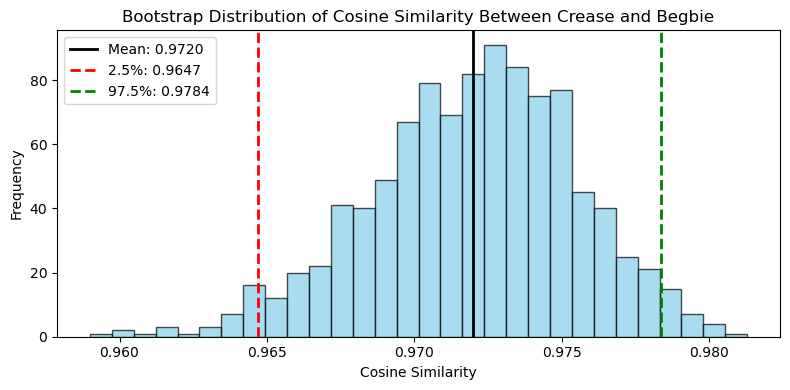

Bootstrap mean cosine similarity between Crease and Begbie: 0.9720
95% Confidence Interval: [0.9647, 0.9784]


In [23]:
import matplotlib.pyplot as plt
# We can bootstrap the similarity score to get a confidence interval
crease_embeddings = np.array(embeddings_dict["Crease"])
begbie_embeddings = np.array(embeddings_dict["Begbie"])

# Convert to arrays
crease_embeddings = np.vstack(crease_embeddings)
begbie_embeddings = np.vstack(begbie_embeddings)

n_boot = 1000 
cosine_scores = []

for _ in range(n_boot):
    # Sample with replacement
    crease_sample = crease_embeddings[np.random.choice(len(crease_embeddings), size=len(crease_embeddings), replace=True)]
    begbie_sample = begbie_embeddings[np.random.choice(len(begbie_embeddings), size=len(begbie_embeddings), replace=True)]
    
    # Compute mean embeddings
    mean_crease_boot = np.mean(crease_sample, axis=0, keepdims=True)
    mean_begbie_boot = np.mean(begbie_sample, axis=0, keepdims=True)
    
    # Compute cosine similarity
    cos_sim = cosine_similarity(mean_crease_boot, mean_begbie_boot)[0][0]
    cosine_scores.append(cos_sim)

# Convert to numpy array
cosine_scores = np.array(cosine_scores)

# Compute 95% confidence interval
lower = np.percentile(cosine_scores, 2.5)
upper = np.percentile(cosine_scores, 97.5)
mean_sim = np.mean(cosine_scores)

# Plot the bootstrap distribution
plt.figure(figsize=(8, 4))
plt.hist(cosine_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add lines for mean and confidence interval
plt.axvline(mean_sim, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_sim:.4f}')
plt.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'2.5%: {lower:.4f}')
plt.axvline(upper, color='green', linestyle='--', linewidth=2, label=f'97.5%: {upper:.4f}')

plt.title('Bootstrap Distribution of Cosine Similarity Between Crease and Begbie')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Print the results
print(f"Bootstrap mean cosine similarity between Crease and Begbie: {mean_sim:.4f}")
print(f"95% Confidence Interval: [{lower:.4f}, {upper:.4f}]")

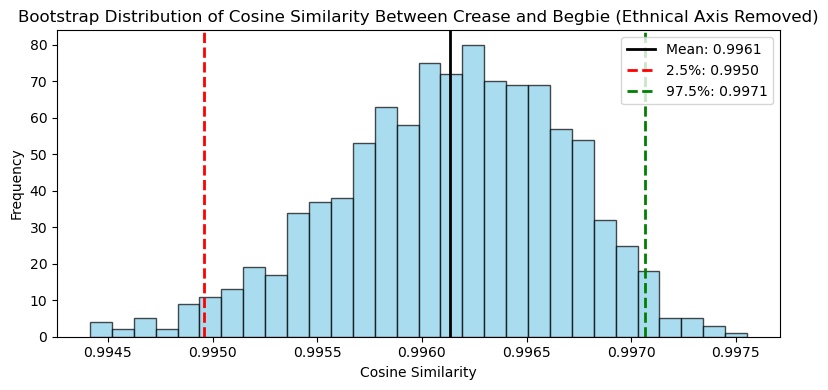

Bootstrap mean cosine similarity between Crease and Begbie with ethnical axis removed: 0.9961
95% Confidence Interval: [0.9950, 0.9971]


In [24]:
# Similarly, bootstrap the similarity score to get a confidence interval
crease_embeddings = np.array(subtracted_embeddings_dict["Crease"])
begbie_embeddings = np.array(subtracted_embeddings_dict["Begbie"])

# Convert to arrays
crease_embeddings = np.vstack(crease_embeddings)
begbie_embeddings = np.vstack(begbie_embeddings)

n_boot = 1000 
subtracted_cosine_scores = []

for _ in range(n_boot):
    # Sample with replacement
    crease_sample = crease_embeddings[np.random.choice(len(crease_embeddings), size=len(crease_embeddings), replace=True)]
    begbie_sample = begbie_embeddings[np.random.choice(len(begbie_embeddings), size=len(begbie_embeddings), replace=True)]
    
    # Compute mean embeddings
    mean_crease_boot = np.mean(crease_sample, axis=0, keepdims=True)
    mean_begbie_boot = np.mean(begbie_sample, axis=0, keepdims=True)
    
    # Compute cosine similarity
    cos_sim = cosine_similarity(mean_crease_boot, mean_begbie_boot)[0][0]
    subtracted_cosine_scores.append(cos_sim)

# Convert to numpy array
subtracted_cosine_scores = np.array(subtracted_cosine_scores)

# Compute 95% confidence interval
lower = np.percentile(subtracted_cosine_scores, 2.5)
upper = np.percentile(subtracted_cosine_scores, 97.5)
mean_sim = np.mean(subtracted_cosine_scores)

# Plot the bootstrap distribution
plt.figure(figsize=(8, 4))
plt.hist(subtracted_cosine_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add lines for mean and confidence interval
plt.axvline(mean_sim, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_sim:.4f}')
plt.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'2.5%: {lower:.4f}')
plt.axvline(upper, color='green', linestyle='--', linewidth=2, label=f'97.5%: {upper:.4f}')

plt.title('Bootstrap Distribution of Cosine Similarity Between Crease and Begbie (Ethnical Axis Removed)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Print the results
print(f"Bootstrap mean cosine similarity between Crease and Begbie with ethnical axis removed: {mean_sim:.4f}")
print(f"95% Confidence Interval: [{lower:.4f}, {upper:.4f}]")

In [25]:
# Testing if the ethnical axis removal has a significant effect on the similarity score
# We can use a bootstrapped t-test to compare the means of the two distributions
from scipy.stats import ttest_ind

# Perform bootstrapped t-test
t_stat, p_value = ttest_ind(subtracted_cosine_scores, cosine_scores, equal_var=False)

# Print the results
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("The difference in mean cosine similarity is statistically significant.")
else:
    print("The difference in mean cosine similarity is not statistically significant.")

t-statistic: 215.1226
p-value: 0.0000
The difference in mean cosine similarity is statistically significant.


With the above test on embeddings with or without the ethnical axis, we confirmed that the difference between cosine similarities of Crease and Begbie are statistically significantly biased by the ethnical factors. However, with the small difference in real cosine similarity, we can conclude that the two characters are still very similar in terms of their text embeddings, thus the bias is not very significant in the real world. 

In [26]:
# Create UMAP projection for visualization
!pip install umap-learn
import umap 

all_vecs = np.vstack(embeddings_dict["Crease"] + embeddings_dict["Begbie"])
labels  = (["Crease"] * len(embeddings_dict["Crease"])) + (["Begbie"] * len(embeddings_dict["Begbie"]))

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
proj = reducer.fit_transform(all_vecs) 

In [27]:
# plot using plotly to further explore
import plotly.express as px
import textwrap

def wrap_text(text, width=60):
    return '<br>'.join(textwrap.wrap(text, width=width))

umap_df = pd.DataFrame(proj, columns=['UMAP 1', 'UMAP 2'])
umap_df['Author'] = labels
umap_df['Text'] = [snip for auth in judge_snippets for snip in judge_snippets[auth]]
umap_df['Text'] = umap_df['Text'].apply(lambda t: wrap_text(t, width=50))

fig = px.scatter(umap_df, x='UMAP 1', y='UMAP 2', 
                 color='Author', hover_data=['Text'], 
                 width=800, height=500 )
fig.update_traces(marker=dict(size=5))
fig.update_layout(title='UMAP Projection of Word Embeddings by Author')
fig.show()

In [28]:
# Print out the 10 most similar embedding sentences to Crease's mean embedding
from sklearn.metrics.pairwise import cosine_similarity

crease_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in judge_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_crease)[0][0]
        crease_similarity_df.loc[len(crease_similarity_df)] = [
            auth, snippet, similarity
        ]

# Sort by similarity score
crease_sorted_similarity = crease_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to Crease's mean embedding:\n")

for _, row in crease_sorted_similarity.head(10).iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to Crease's mean embedding:

Author: Crease
Sentence: The Act is found associated with another Act now disallowed, the express object of which is to
prevent the Chinese altogether from coming to this country, and the principle "noscitur a sociis" is
kept up by the preamble of the present Act, which describes the Chinese in terms which, I venture to
think, have never before in any other country found a place in an Act of Parliament.
Similarity Score: 0.8746

Author: Crease
Sentence: In the case of the Chinese treaties, they were forced at the point of the bayonet on China, to
obtain a right for us to enter China, and in return for a similar permission to us, full permission
was given for the Chinese to trade and reside in British dominions everywhere.
Similarity Score: 0.8526

Author: Crease
Sentence: In other words, every Chinese is guilty until proved innocent—a provision which fills one conversant
with subjects with alarm; for if such a law can be tolera

In [29]:
# Print out the 10 most similar embedding sentences to Begbie's mean embedding
begbie_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in judge_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_begbie)[0][0]
        begbie_similarity_df.loc[len(begbie_similarity_df)] = [
            auth, snippet, similarity
        ]

# Sort by similarity score
begbie_sorted_similarity = begbie_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to Begbie's mean embedding:\n")

for _, row in begbie_sorted_similarity.head(10).iterrows():
    
    wrapped_para = textwrap.fill(row['Text'], width=100)
    
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to Begbie's mean embedding:

Author: Begbie
Sentence: I have no doubt but that compulsion is put on all Chinamen, so that it is very difficult for them to
obtain work, if they remain outside this organization.
Similarity Score: 0.8694

Author: Crease
Sentence: Though possessed of all the qualities I have described, Chinamen do not make good settlers in the
sense of raising up citizens of a free.
Similarity Score: 0.8452

Author: Begbie
Sentence: I don't think serious breaches of the peace are proportionately more frequent in Chinese brothels
than in those kept by white women.
Similarity Score: 0.8424

Author: Begbie
Sentence: I have an indistinct remembrance of having been once asked to contribute to the cost of removing a
disabled Chinaman; I am not sure.
Similarity Score: 0.8414

Author: Crease
Sentence: This is not because they have not credit, for Chinese merchants, punctual to the day and hour in
monetary engagements, can obtain what credit they pleas

The mixture occurrence of the two judges in the most similar sentences to the mean embeddings of the two also shows that the stance are very similar in terms of their text embeddings. 

### The Comparison of Crease's and Begbie's Rulings and the Chinese Regulation Act of 1884

In [30]:
crease_cases = df[(df['author'] == 'Crease') & (df['type'] == 'case')]['text'].tolist()
begbie_cases = df[(df['author'] == 'Begbie') & (df['type'] == 'case')]['text'].tolist()
act_1884 = df[df['type'] == 'act']['text'].tolist()

act_dict = {
    'Crease': crease_cases,
    'Begbie': begbie_cases,
    'Act 1884': act_1884}

In [31]:
act_snippets = {}

keywords = ["Chinese", "China", "Chinaman", "Chinamen"]
for auth, texts in act_dict.items():
    snippets = []
    for txt in texts:
        sentence = sent_tokenize(txt)
        for sent in sentence:
            if any(keyword in sent for keyword in keywords):
                snippets.append(sent)
    act_snippets[auth] = snippets

In [32]:
# Investigate the length of the snippets
n_snippet = {auth: len(snippets) for auth, snippets in act_snippets.items()}

print("Snippet size by author:")
for auth, num in n_snippet.items():
    print(f"{auth}: {num}")

Snippet size by author:
Crease: 77
Begbie: 18
Act 1884: 24


In [33]:
# Create embeddings
embeddings_dict = {'Crease': [], 'Begbie': [], 'Act 1884': []}

for auth, snippets in act_snippets.items():
    for snip in snippets:
        v = embed_text(snip, focus_token=keywords, window=15)
        embeddings_dict[auth].append(v[:256]) # Keep only the first 256 dimensions

In [34]:
# Create embeddings that subtract the ethnicity anchor
subtracted_embeddings_dict = {'Crease': [], 'Begbie': [], 'Act 1884': []}

for auth, embeddings in embeddings_dict.items():
    for emb in embeddings:
        v = emb - eth_anchor
        subtracted_embeddings_dict[auth].append(v)

In [35]:
# Compute the pairwise cosine similarity
mean_crease = np.mean(embeddings_dict["Crease"], axis=0, keepdims=True)
mean_begbie = np.mean(embeddings_dict["Begbie"], axis=0, keepdims=True)
mean_act_1884 = np.mean(embeddings_dict["Act 1884"], axis=0, keepdims=True)

sim_crease_begbie = cosine_similarity(mean_crease, mean_begbie)[0, 0]
sim_crease_act_1884 = cosine_similarity(mean_crease, mean_act_1884)[0, 0]
sim_begbie_act_1884 = cosine_similarity(mean_begbie, mean_act_1884)[0, 0]

print(f"Cosine similarity between Crease and Begbie: {sim_crease_begbie:.4f}")
print(f"Cosine similarity between Crease and Act 1884: {sim_crease_act_1884:.4f}")
print(f"Cosine similarity between Begbie and Act 1884: {sim_begbie_act_1884:.4f}")

Cosine similarity between Crease and Begbie: 0.9527
Cosine similarity between Crease and Act 1884: 0.9030
Cosine similarity between Begbie and Act 1884: 0.8657


In [36]:
# Compute the pairwise cosine similarity by max and min poolings
max_crease = np.max(embeddings_dict["Crease"], axis=0, keepdims=True)
min_crease = np.min(embeddings_dict["Crease"], axis=0, keepdims=True)
max_begbie = np.max(embeddings_dict["Begbie"], axis=0, keepdims=True)
min_begbie = np.min(embeddings_dict["Begbie"], axis=0, keepdims=True)
max_act_1884 = np.max(embeddings_dict["Act 1884"], axis=0, keepdims=True)
min_act_1884 = np.min(embeddings_dict["Act 1884"], axis=0, keepdims=True)

# Compute the pairwise cosine similarity
sim_crease_begbie_max = cosine_similarity(max_crease, max_begbie)[0, 0]
sim_crease_begbie_min = cosine_similarity(min_crease, min_begbie)[0, 0]
sim_crease_act_1884_max = cosine_similarity(max_crease, max_act_1884)[0, 0]
sim_crease_act_1884_min = cosine_similarity(min_crease, min_act_1884)[0, 0]
sim_begbie_act_1884_max = cosine_similarity(max_begbie, max_act_1884)[0, 0]
sim_begbie_act_1884_min = cosine_similarity(min_begbie, min_act_1884)[0, 0]

# Print the results
print(f"Cosine similarity between max Crease and max Begbie: {sim_crease_begbie_max:.4f}")
print(f"Cosine similarity between min Crease and min Begbie: {sim_crease_begbie_min:.4f}")
print(f"Cosine similarity between max Crease and max Act 1884: {sim_crease_act_1884_max:.4f}")
print(f"Cosine similarity between min Crease and min Act 1884: {sim_crease_act_1884_min:.4f}")
print(f"Cosine similarity between max Begbie and max Act 1884: {sim_begbie_act_1884_max:.4f}")
print(f"Cosine similarity between min Begbie and min Act 1884: {sim_begbie_act_1884_min:.4f}")

Cosine similarity between max Crease and max Begbie: 0.9527
Cosine similarity between min Crease and min Begbie: 0.9391
Cosine similarity between max Crease and max Act 1884: 0.9371
Cosine similarity between min Crease and min Act 1884: 0.9291
Cosine similarity between max Begbie and max Act 1884: 0.9174
Cosine similarity between min Begbie and min Act 1884: 0.9159


In [37]:
# Compute the pairwise cosine similarity with subtracted embeddings
subtracted_mean_crease = np.mean(subtracted_embeddings_dict["Crease"], axis=0, keepdims=True)
subtracted_mean_begbie = np.mean(subtracted_embeddings_dict["Begbie"], axis=0, keepdims=True)
subtracted_mean_act_1884 = np.mean(subtracted_embeddings_dict["Act 1884"], axis=0, keepdims=True)

sim_crease_begbie_sub = cosine_similarity(subtracted_mean_crease, subtracted_mean_begbie)[0, 0]
sim_crease_act_1884_sub = cosine_similarity(subtracted_mean_crease, subtracted_mean_act_1884)[0, 0]
sim_begbie_act_1884_sub = cosine_similarity(subtracted_mean_begbie, subtracted_mean_act_1884)[0, 0]

print(f"Cosine similarity between Crease and Begbie with ethnical axis removed: {sim_crease_begbie_sub:.4f}")
print(f"Cosine similarity between Crease and Act 1884 with ethnical axis removed: {sim_crease_act_1884_sub:.4f}")
print(f"Cosine similarity between Begbie and Act 1884 with ethnical axis removed: {sim_begbie_act_1884_sub:.4f}")

Cosine similarity between Crease and Begbie with ethnical axis removed: 0.9934
Cosine similarity between Crease and Act 1884 with ethnical axis removed: 0.9830
Cosine similarity between Begbie and Act 1884 with ethnical axis removed: 0.9770


In [38]:
# Create UMAP projection for visualization
import umap 

all_vecs = np.vstack(embeddings_dict["Crease"] + embeddings_dict["Begbie"] + embeddings_dict["Act 1884"])
labels  = (["Crease"] * len(embeddings_dict["Crease"])) + (["Begbie"] * len(embeddings_dict["Begbie"])) + (['Act 1884'] * len(embeddings_dict["Act 1884"]))

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
proj = reducer.fit_transform(all_vecs) 

In [39]:
umap_df = pd.DataFrame(proj, columns=['UMAP 1', 'UMAP 2'])
umap_df['Author'] = labels
umap_df['Text'] = [snip for auth in act_snippets for snip in act_snippets[auth]]
umap_df['Text'] = umap_df['Text'].apply(lambda t: wrap_text(t, width=50))

fig = px.scatter(umap_df, x='UMAP 1', y='UMAP 2', 
                 color='Author', hover_data=['Text'], 
                 width=800, height=500 )
fig.update_traces(marker=dict(size=5))
fig.update_layout(title='UMAP Projection of Word Embeddings by Author')
fig.show()

In [40]:
# Print out the 10 most similar embedding sentences to Crease's mean embedding
crease_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in act_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_crease)[0][0]
        crease_similarity_df.loc[len(crease_similarity_df)] = [
            auth, snippet, similarity
        ]
        
# Sort by similarity score
crease_sorted_similarity = crease_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to Crease's mean embedding:\n")
for _, row in crease_sorted_similarity.head(10).iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to Crease's mean embedding:

Author: Crease
Sentence: The Act is found associated with another Act now disallowed, the express object of which is to
prevent the Chinese altogether from coming to this country, and the principle "noscitur a sociis" is
kept up by the preamble of the present Act, which describes the Chinese in terms which, I venture to
think, have never before in any other country found a place in an Act of Parliament.
Similarity Score: 0.8849

Author: Crease
Sentence: The grounds alleged by the Health Officer for this arbitrary treatment is “that China is an infected
locality,” and all persons coming from China and especially in this instance Hongkong, and
especially also the natives of China, come from an infected locality, and that he has that authority
under the Health By-Law, 1893, which was passed at the time of the small pox panic in Victoria, and,
in all he did, was simply doing his duty.
Similarity Score: 0.8538

Author: Crease
Senten

In [41]:
# Print out the 10 most similar embedding sentences to the Regulation Act's mean embedding

regulation_similarity_df = pd.DataFrame(columns=['Author', 'Text', 'Similarity Score'])

# Iterate through the embeddings and their corresponding sentences
for auth, snippets in act_snippets.items():
    for snippet, emb in zip(snippets, embeddings_dict[auth]):
        similarity = cosine_similarity(emb.reshape(1, -1), mean_act_1884)[0][0]
        regulation_similarity_df.loc[len(regulation_similarity_df)] = [
            auth, snippet, similarity
        ]
        
# Sort by similarity score
regulation_sorted_similarity = regulation_similarity_df.sort_values(by='Similarity Score', ascending=False)

print("Top 10 most similar sentences to the Regulation Act's mean embedding:\n")
for _, row in regulation_sorted_similarity.head(10).iterrows():
    wrapped_para = textwrap.fill(row['Text'], width=100)
    print(f"Author: {row['Author']}\nSentence: {wrapped_para}\nSimilarity Score: {row['Similarity Score']:.4f}\n")

Top 10 most similar sentences to the Regulation Act's mean embedding:

Author: Act 1884
Sentence: In case any employer of Chinese fails to deliver to the Collector the list mentioned in the
preceding section, when required so to do, or knowingly states anything falsely therein, such
employer shall, on complaint of the Collector and upon conviction before a Justice of the Peace
having jurisdiction within the district wherein such employer carries on his business, forfeit and
pay a fine not exceeding one hundred dollars for every Chinese in his employ, to be recovered by
distress of the goods and chattels of such employer failing to pay the same, or in lieu thereof
shall be liable to imprisonment for a period not less than one month and not exceeding two calendar
months.
Similarity Score: 0.9057

Author: Act 1884
Sentence: It shall be unlawful for any person to employ any Chinese who has not in his possession the licence
required by this Act, and any person guilty of an infraction of the

### Zero-shot Stance Classification with legal-BERT

In [42]:
# Create the full snippets dictionary
act_1884_full = " ".join(act_1884)
crease_cases_full = " ".join(crease_cases)
begbie_cases_full = " ".join(begbie_cases)

In [43]:
full_cases = {"act_1884": act_1884_full, "crease": crease_cases_full, "begbie": begbie_cases_full}

full_snippets = {}
for author, text in full_cases.items():
    sentence = sent_tokenize(text)
    full_snippets[author] = sentence

In [44]:
len(full_snippets["act_1884"]), len(full_snippets["crease"]), len(full_snippets["begbie"])

(71, 345, 260)

In [45]:
# Create pipeline for zero-shot classification
from transformers import pipeline

zero_shot = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    tokenizer="facebook/bart-large-mnli",
    hypothesis_template="This legal text {}."
)

labels = [
    "advocates for equal legal treatment of Chinese immigrants compared to white or European settlers, opposing racial discrimination",
    "describes the status or treatment of Chinese immigrants without expressing support or opposition to racial inequality",
    "justifies or reinforces unequal legal treatment of Chinese immigrants relative to white or European settlers, supporting racially discriminatory policies"
]

def get_scores(snippet):
    out = zero_shot(snippet, candidate_labels=labels)
    return dict(zip(out["labels"], out["scores"]))

config.json: 0.00B [00:00, ?B/s]

C:\Users\alexr\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alexr\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [46]:
# Run zero-shot classification on the snippets from the Chinese Regulation Act 1884
act_scores = {}

for auth, snippets in full_snippets.items():
    scores = []
    for snip in snippets:
        score = get_scores(snip)
        scores.append(score)
    act_scores[auth] = scores

rows = []

for auth, snippets in full_snippets.items():
    for snip, score_dict in zip(snippets, act_scores[auth]):
        row = {
            "Author": auth,
            "Text": snip,
            "Pro": score_dict[labels[0]],
            "Neutral": score_dict[labels[1]],
            "Cons": score_dict[labels[2]]
        }
        rows.append(row)

# Create long-form DataFrame
df_scores = pd.DataFrame(rows)

# Group by author and calculate mean scores
mean_scores = df_scores.groupby("Author")[["Pro", "Neutral", "Cons"]].mean()

print("Mean scores by author:")
print(mean_scores)


Mean scores by author:
              Pro   Neutral      Cons
Author                               
act_1884  0.33126  0.215666  0.453074
begbie    0.31126  0.295173  0.393568
crease    0.27897  0.276515  0.444515


In [47]:
df_scores['Text'] = df_scores['Text'].apply(lambda t: wrap_text(t, width = 50))

fig = px.scatter(
    df_scores,
    x="Pro",
    y="Cons",
    color="Author",
    hover_data=["Text"],
    title="Pros vs Cons Scores by Author",
    width=800,
    height=600
)

fig.update_traces(marker=dict(size=5))
fig.show()

In [48]:
# Plot histogram for Pro scores
fig_pro = px.histogram(
    df_scores,
    x="Pro",
    color="Author",
    title="Distribution of Pro Scores by Author",
    nbins=30,
    opacity=0.7,
    labels={"Pro": "Pro Score"}
)
fig_pro.update_layout(
    xaxis_title="Pro Score",
    yaxis_title="Frequency",
    width=800,
    height=500
)
fig_pro.show()

# Plot histogram for Cons scores
fig_cons = px.histogram(
    df_scores,
    x="Cons",
    color="Author",
    title="Distribution of Cons Scores by Author",
    nbins=30,
    opacity=0.7,
    labels={"Cons": "Cons Score"}
)
fig_cons.update_layout(
    xaxis_title="Cons Score",
    yaxis_title="Frequency",
    width=800,
    height=500
)
fig_cons.show()

### Revisit Begbie and Crease's Rulings with Quotations Removed

In [ ]:
### Read in the two files
#File is meta_data_cleaned.csv


### Domain‐Adaptive Pretraining